# Supervised Fine-Tuning for Sentiment Classification

텍스트 분류는 자연어처리의 대표적인 태스크로 주어진 텍스트를 여러개 카테고리로 분류하는 기술입니다.  
감성 분석(Sentiment Analysis)이 대표적인 예입니다.  
본 실습에서는 사전학습된 언어모델 DistilBERT를 활용해서 감성 분석을 파인튜닝하는 과정에 대해 살펴보겠습니다.

## 0. Setup

In [1]:
# MLP Suwon 설정 필요 
import os

os.environ['REQUESTS_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
os.environ['HTTP_PROXY'] ='http://75.17.107.42:8080'
os.environ['HTTPS_PROXY'] ='http://75.17.107.42:8080'

In [2]:
import ssl

if hasattr(ssl, '_create_unverified_context'):
    ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# !pip install -q --user transformers==4.38.2
# !pip install -q --user datasets==2.18.0

In [3]:
!nvidia-smi

Tue Oct 22 12:34:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:04:00.0 Off |                  Off |
| N/A   25C    P8     9W / 250W |      0MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 1. DataSets

허깅페이스 허브에서 제공하는 "emotion" 데이터셋을 파인튜닝에 사용하도록 하겠습니다.

Emotion 데이터셋은 Train Set 16,000개, Validation Set 2,000개, Test Set 2,000개로 구성되어 있습니다.

In [4]:
from datasets import load_dataset

# [실습] 다음 코드를 완성하세요!! 
# "emotion" 데이터셋을 가져옵니다.
# emotions = load_dataset("emotion")
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Emotion 데이터셋의 레이블은 총 6개 카데고리로 구성되어 있습니다 (Sadness, Joy, Love, Anger, Fear, Surprise)

In [6]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


데이터셋의 포맷과 카테고리별 분포 등에 대해 살펴 보겠습니다.  

In [8]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


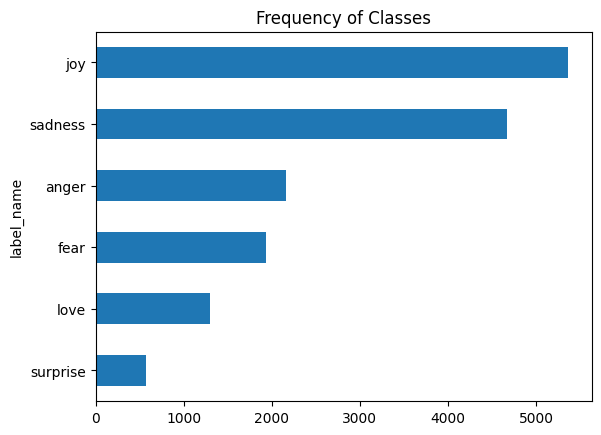

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

DataFrame 포맷으로부터 데이터셋 출력 포맷 초기화

In [11]:
emotions.reset_format()

## 2. Tokenization

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

텍스트를 토큰으로 분할하고 각 토큰을 정수로 매핑합니다.
\[CLS\]와 \[SEP\]는 시퀀스의 시작과 끝을 의미하며, ##IZING와 같이 '##'은 앞 토큰과 공백으로 분리된 것이 아니라, 
앞의 토큰과 연결된 단어였음을 의미합니다.

In [13]:
from transformers import AutoTokenizer

# [실습] 다음 코드를 완성하세요!! 
# 사전학습 모델 'distilbert-base-uncased'에 사용된 Tokenizer를 가져옵니다.
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [16]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [17]:
tokenizer.vocab_size

30522

In [18]:
tokenizer.model_max_length

512

학습에 사용할 emotion 데이터를 토크나이즈하여, LLM Fine-Tuning을 위한 사전 준비를 합니다.

In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [20]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [21]:
# 다음 코드를 완성하세요!! 
# Dataset.map Method를 이용하여 emotions 데이터셋의 텍스트를 토크화 합니다.
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [22]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 3. Fine-Tuning

텍스트 분류 파인튜닝을 위해 사전학습된 언어모델 **DistilBERT**를 기반으로 **SquenceClassification Task Head**를 구성합니다.

In [23]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

# [실습] 다음 코드를 완성하세요!!
# 사전학습 모델을 기반으로 Sequence Classification 모델을 구성합니다.
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

model_size = sum(t.numel() for t in model.parameters())
print(f"Model: {model_size/1000**2:.1f}M parameters")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /group-volume/sr_edu/AI-Application-Specialist/LLM/model/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: 67.0M parameters


In [24]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [25]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

# [실습] 다음 코드를 완성하세요!!
# 학습 파라미터 설정를 설정합니다.
training_args = TrainingArguments(output_dir="test-trainer",
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  dataloader_num_workers=4,
                                  dataloader_prefetch_factor=2,)

파인튜닝을 진행합니다. 학습 시간은 5번의 에포크를 수행하는데 약 6~7분 정도 소요됩니다.

In [26]:
from transformers import Trainer

# [실습] 다음 코드를 완성하세요!!
# Trainer를 설정합니다.: model, args, compute_metrics, train_dataset, eval_dataset, tokenizer
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.803700,0.272986,0.915000,0.915564
2,0.209400,0.167634,0.934000,0.934485
3,0.137800,0.155107,0.936000,0.936691
4,0.103800,0.152903,0.938000,0.937964
5,0.092000,0.148719,0.937000,0.937159


Checkpoint destination directory test-trainer/checkpoint-250 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [27]:
preds_output = trainer.predict(emotions_encoded["test"])

In [28]:
preds_output.metrics

{'test_loss': 0.1598426252603531,
 'test_accuracy': 0.9245,
 'test_f1': 0.9241837225210205,
 'test_runtime': 2.5121,
 'test_samples_per_second': 796.145,
 'test_steps_per_second': 12.738}

In [ ]:
# model.save_pretrained('./test-trainer/best_model')

## 4. Inference

In [29]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.eval()

input_text = "I saw a movie today and it was really good."

encoded_input = tokenizer(input_text, return_tensors='pt')
emcoded_input = encoded_input.to(device)

with torch.no_grad():
    outputs = model.forward(**encoded_input)
    logits = outputs.logits

In [30]:
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class_idx = torch.argmax(probabilities, dim=-1).item()

print(f"Input text: {input_text}")
print(f"Predicted class index: {predicted_class_idx}")
print(f"Predicted label: {label_int2str(predicted_class_idx)}")
print(f"Class probability: {probabilities}")

Input text: I saw a movie today and it was really good.
Predicted class index: 1
Predicted label: joy
Class probability: tensor([[2.2610e-03, 9.9204e-01, 1.3912e-03, 2.4212e-03, 1.0460e-03, 8.3791e-04]],
       device='cuda:0')


- Ref. Natural Language Processing with Transformers